# Env instructions

```bash
conda create -n 202108-pykaldi-c11 python=3.7
conda activate 202108-pykaldi-c11
conda install mamba -c conda-forge
mamba install pytorch torchvision torchaudio cudatoolkit=11.0 pykaldi matplotlib tqdm ipython scipy psutil progressbar ptvsd requests cython patchelf graphviz jupyterlab unidecode sentencepiece numba -c conda-forge -c pytorch -c pykaldi
pip install git+https://github.com/jpuigcerver/openfst-python.git
```

In [2]:
import io
from collections import defaultdict, namedtuple, Counter

import unidecode

import numpy as np
from scipy.special import logsumexp, digamma

import kaldi.fstext as fst
# import openfst_python as fst
import sentencepiece as spm

from kaldi_fst_sp import *

In [3]:
# TEXT = open('botchan.txt').read()

TEXT='abababaabb cacacacacacacaca acacacacacac ca caca cacaca ac acac acacac abcabcabcabcabcab'
TEXT = unidecode.unidecode(TEXT.lower())  #.replace(' ', '')
SENTENCES_BY_SPACE = [Sentence(text, count) for text, count in Counter(TEXT.split()).items()]
SENTENCES = [Sentence(line.strip(), 1) for line in TEXT.split('\n') if line.strip()]
TEXT = '\n'.join([s[0] for s in SENTENCES])
print(SENTENCES)

[Sentence(text='abababaabb cacacacacacacaca acacacacacac ca caca cacaca ac acac acacac abcabcabcabcabcab', count=1)]


In [4]:
# Get the reference sentencpieces
model=io.BytesIO()
spm.SentencePieceTrainer.train(
    sentence_iterator=io.BytesIO(TEXT.encode()),
    model_writer=model,
    vocab_size=8, 
    shrinking_factor=0.85,
    num_sub_iterations=10
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 8
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.85
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 10
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
tr

In [9]:
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
FINAL_PIECES = list(extract_pieces(sp))
print(f"Tot unigram prob: {np.exp(logsumexp([piece.log_freq for piece in FINAL_PIECES if piece.log_freq != 0.0]))}")
FINAL_PIECES[:100]

Tot unigram prob: 0.8163016306690613


[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.4352858066558838),
 SentencePiece(index=4, symbol='ab', log_freq=-2.0434062480926514),
 SentencePiece(index=5, symbol='▁', log_freq=-4.326545715332031),
 SentencePiece(index=6, symbol='c', log_freq=-4.326645374298096),
 SentencePiece(index=7, symbol='a', log_freq=-4.326745510101318)]

In [62]:
# Get the initial vocab

model=io.BytesIO()
spm.SentencePieceTrainer.train(
    sentence_iterator=io.BytesIO(TEXT.encode()),
    model_writer=model,
    vocab_size=17,
    num_sub_iterations=1
    
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 17
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 1
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
tr

In [63]:
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
INITIAL_PIECES = list(extract_pieces(sp))
print(f"Tot unigram prob: {np.exp(logsumexp([piece.log_freq for piece in INITIAL_PIECES if piece.log_freq != 0.0]))}")
INITIAL_PIECES[:100]

Tot unigram prob: 0.6545648024932031


[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='▁caca', log_freq=-2.6853573322296143),
 SentencePiece(index=4, symbol='▁cacaca', log_freq=-2.7242918014526367),
 SentencePiece(index=5, symbol='▁ab', log_freq=-2.7418582439422607),
 SentencePiece(index=6, symbol='▁ca', log_freq=-2.7452681064605713),
 SentencePiece(index=7, symbol='▁acac', log_freq=-2.8035264015197754),
 SentencePiece(index=8, symbol='▁ac', log_freq=-2.810230255126953),
 SentencePiece(index=9, symbol='▁acacac', log_freq=-2.9112017154693604),
 SentencePiece(index=10, symbol='b', log_freq=-3.0529541969299316),
 SentencePiece(index=11, symbol='ab', log_freq=-3.0605990886688232),
 SentencePiece(index=12, symbol='ababa', log_freq=-3.1826658248901367),
 SentencePiece(index=13, symbol='▁', log_freq=-3.6624233722686768),
 SentencePiece(index=14, symbol='c', log_freq=-3.9868173599243164),

In [12]:
import importlib
import kaldi_fst_sp
importlib.reload(kaldi_fst_sp)
from kaldi_fst_sp import *

In [65]:
T = SentencePieceTrainer(INITIAL_PIECES)
# T = SentencePieceTrainer(FINAL_PIECES)
for a in fst.SymbolTableIterator(T.PIECE_SYMB):
    print(a)


(0, '<eps>')
(1, '<s>')
(2, '</s>')
(3, '▁caca')
(4, '▁cacaca')
(5, '▁ab')
(6, '▁ca')
(7, '▁acac')
(8, '▁ac')
(9, '▁acacac')
(10, 'b')
(11, 'ab')
(12, 'ababa')
(13, '▁')
(14, 'c')
(15, 'a')
(16, '▁a')


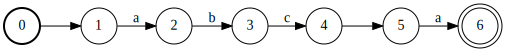

In [66]:
T.text_to_fst('abc a')

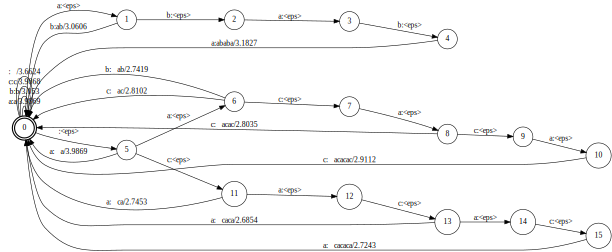

In [67]:
sp_to_chr = T.get_sp_to_char(INITIAL_PIECES, arc_type='log')
sp_to_chr

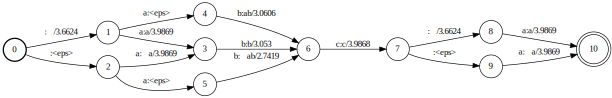

In [68]:
sentence = 'abc a'
# sentence = SENTENCES_BY_SPACE[3][0]
lattice = T.get_lattice_naive(sentence, T.get_sp_to_char(INITIAL_PIECES))
lattice

In [69]:
T.compute_piece_counts_naive(sentence, T.get_sp_to_char(INITIAL_PIECES))

PieceCounts(Z=10.658158302307129, counts=defaultdict(<class 'float'>, {13: 0.043440237520893474, 15: 0.025365740041493418, 16: 0.988138216606856, 10: 0.013504194035922474, 11: 0.018074516547870796, 5: 0.9684213172487539, 14: 0.9999997615814493}))

In [71]:
T.viterbi_naive(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)

[ViterbiPath(path=[5, 14, 16], prob=0.9441836768129545),
 ViterbiPath(path=[5, 14, 13, 15], prob=0.024237410982522353)]

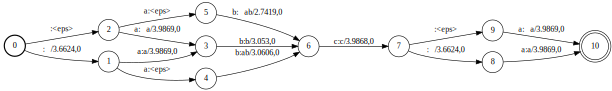

In [72]:
lattice = T.get_lattice(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'))
lattice

In [73]:
T.compute_piece_counts(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'))

PieceCounts(Z=10.658158302307129, counts=defaultdict(<class 'float'>, {13: 0.043440237520893474, 15: 0.025365740041493418, 16: 0.988138216606856, 10: 0.013504194035922474, 11: 0.018074516547870796, 5: 0.9684213172487539, 14: 0.9999997615814493}))

In [74]:
T.viterbi(sentence, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)

[ViterbiPath(path=[5, 14, 16], prob=0.9441836768129545),
 ViterbiPath(path=[5, 14, 13, 15], prob=0.024237410982522353)]

In [75]:
# TODO: verify why EM returns different results, when our Viterbi seems to be OK
assert len(sp.tokenize(SENTENCES[0][0])) == len(T.viterbi(SENTENCES[0][0], T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])
print(list(zip(sp.tokenize(SENTENCES[0][0]), T.viterbi(SENTENCES[0][0], T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])))

[(5, 5), (12, 12), (11, 11), (10, 10), (4, 4), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (9, 9), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (6, 6), (3, 3), (4, 4), (8, 8), (7, 7), (9, 9), (5, 5), (14, 14), (11, 11), (14, 14), (11, 11), (14, 14), (11, 11), (14, 14), (11, 11), (14, 14), (11, 11)]


In [76]:
for S, _ in SENTENCES_BY_SPACE[:10]:
    assert len(sp.tokenize(S)) == len(T.viterbi(S, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])
    print(list(zip(sp.tokenize(S), T.viterbi(S, T.get_sp_to_char(INITIAL_PIECES, 'standard'), nshortest=2)[0][0])))

[(5, 5), (12, 12), (11, 11), (10, 10)]
[(4, 4), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15)]
[(9, 9), (15, 15), (14, 14), (15, 15), (14, 14), (15, 15), (14, 14)]
[(6, 6)]
[(3, 3)]
[(4, 4)]
[(8, 8)]
[(7, 7)]
[(9, 9)]
[(5, 5), (14, 14), (11, 11), (14, 14), (11, 11), (14, 14), (11, 11), (14, 14), (11, 11), (14, 14), (11, 11)]


In [78]:
# Sentencepiece training
pieces = INITIAL_PIECES
sentences = SENTENCES_BY_SPACE

DESIRED_PIECES = 6
PRUNE_FRAC = 0.85
NUM_SUBITER = 10

while True:
    # EM Step
    for sub_iter in range(NUM_SUBITER):  # num_sub_iterations
        e_ret = T.EStep(pieces, sentences)
        pieces = T.MStep(pieces, e_ret.counts)
        print(f"EM sub_iter={sub_iter} size={len(pieces)} tot_piece_prob={np.exp(logsumexp([piece.log_freq for piece in pieces]))} "
              f"obj={e_ret.objective} num_tokens={e_ret.n_tokens} num_tokens/piece={e_ret.n_tokens / len(pieces)}" )
    
    if len(pieces) <= DESIRED_PIECES:
        break

    pieces = T.prune_pieces(pieces, sentences, DESIRED_PIECES, PRUNE_FRAC)
    if len(pieces) <= DESIRED_PIECES:
        break
        
# TODO: add finalization

EM sub_iter=0 size=12 tot_piece_prob=0.8693918826259943 obj=13.593990206718445 num_tokens=39 num_tokens/piece=3.25
EM sub_iter=1 size=12 tot_piece_prob=0.8727699122224476 obj=8.34394974708557 num_tokens=39 num_tokens/piece=3.25
EM sub_iter=2 size=12 tot_piece_prob=0.8741026377790027 obj=8.337706542015075 num_tokens=39 num_tokens/piece=3.25
EM sub_iter=3 size=12 tot_piece_prob=0.8751727373520849 obj=8.341840457916259 num_tokens=39 num_tokens/piece=3.25
EM sub_iter=4 size=11 tot_piece_prob=0.8838105971649134 obj=8.34699306488037 num_tokens=41 num_tokens/piece=3.727272727272727
EM sub_iter=5 size=11 tot_piece_prob=0.887924411971826 obj=8.348154759407043 num_tokens=41 num_tokens/piece=3.727272727272727
EM sub_iter=6 size=11 tot_piece_prob=0.8878875207681647 obj=8.3336656332016 num_tokens=41 num_tokens/piece=3.727272727272727
EM sub_iter=7 size=11 tot_piece_prob=0.8878791782075109 obj=8.33449227809906 num_tokens=41 num_tokens/piece=3.727272727272727
EM sub_iter=8 size=11 tot_piece_prob=0.88

In [79]:
FINAL_PIECES

[SentencePiece(index=0, symbol='<unk>', log_freq=0.0),
 SentencePiece(index=1, symbol='<s>', log_freq=0.0),
 SentencePiece(index=2, symbol='</s>', log_freq=0.0),
 SentencePiece(index=3, symbol='b', log_freq=-0.4352858066558838),
 SentencePiece(index=4, symbol='ab', log_freq=-2.0434062480926514),
 SentencePiece(index=5, symbol='▁', log_freq=-4.326545715332031),
 SentencePiece(index=6, symbol='c', log_freq=-4.326645374298096),
 SentencePiece(index=7, symbol='a', log_freq=-4.326745510101318)]

In [80]:
pieces

[SentencePiece(index=5, symbol='▁ab', log_freq=-3.7153066688841117),
 SentencePiece(index=6, symbol='▁ca', log_freq=-2.881972788162477),
 SentencePiece(index=8, symbol='▁ac', log_freq=-4.574554712535495),
 SentencePiece(index=10, symbol='b', log_freq=-1.9974501157027285),
 SentencePiece(index=14, symbol='c', log_freq=-1.1629025446167525),
 SentencePiece(index=15, symbol='a', log_freq=-0.9771427975634528)]

In [13]:
import importlib,seed_vocab
importlib.reload(seed_vocab)
from seed_vocab import *

t=SuffixTree("abababaabb_cacacacacacacaca_acacacacacac_ca_caca_cacaca_ac_acac_acacac_abcabcabcabcabcab$")
res=get_vocab(0,t)

sentencepiece_result = "acac acaca acacac caca cacac cacaca acacaca acacacac cacacac cacacaca aca acacacaca ca cac cacacacac acacacacac cacacacaca ac acacacacaca cacacacacac a acacacacacac cacacacacaca abcabcabcab abcabcab c bcabcabcab abcabcabcabcab bcabcab cacacacacacaca cabcabcab acacacacacaca bcabcabcabcab abcab cabcab cabcabcabcab ab bcab cab ▁acac ▁caca ▁acacac ▁cacaca ▁a ▁ac ▁ca b ababa ▁ aba baba ba ▁ab"
my_result = "▁acacac ▁acac ▁ac ▁a ▁cacaca ▁caca ▁ca a▁ac a▁caca a▁ ababa aba abcabcabcabcab abcabcabcab abcabcab abcab ab ac▁acac ac▁a ac▁ aca▁ac aca▁ acac▁a acac▁ acaca▁ac acacac▁ acacacacacaca acacacacacac acacacacaca acacacacac acacacaca acacacac acacaca acacac acaca acac aca ac baba ba bcabcabcabcab bcabcabcab bcabcab bcab c▁acac c▁a c▁ ca▁ac ca▁caca ca▁ cabcabcabcab cabcabcab cabcab cab cac▁a cac▁ caca▁ac caca▁ cacac▁ cacaca▁ac cacacacacacaca cacacacacaca cacacacacac cacacacaca cacacacac cacacaca cacacac cacaca cacac caca cac ca"

res = [x.replace("_","▁") for x in res]

ssr = sorted(sentencepiece_result.split(" "))
smr = sorted(res)

i,j=0,0
while i<len(ssr) and j<len(smr):
    if ssr[i]<smr[j]:
        print(f"{ssr[i]:50}{''}")
        i+=1
    elif ssr[i]==smr[j]:
        print(f"{ssr[i]:50}{smr[j]}")
        i+=1
        j+=1
    else:
        print(f"{'':50}{smr[j]}")
        j+=1
while i<len(ssr):
    print(f"{ssr[i]:50}{''}")
    i+=1
while j<len(smr):
    print(f"{'':50}{smr[j]}")
    j+=1


a                                                 
ab                                                ab
aba                                               aba
ababa                                             ababa
abcab                                             abcab
abcabcab                                          abcabcab
abcabcabcab                                       abcabcabcab
abcabcabcabcab                                    abcabcabcabcab
ac                                                ac
aca                                               aca
acac                                              acac
acaca                                             acaca
acacac                                            acacac
acacaca                                           acacaca
acacacac                                          acacacac
acacacaca                                         acacacaca
acacacacac                                        acacacacac
acacacacaca                    